<a href="https://colab.research.google.com/github/husanaulakh/ENPH-353-Competition-Team12/blob/main/LicenceLearner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import math
import re
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
from keras.utils import plot_model
from ipywidgets import interact
import ipywidgets as ipywidgets
import imgaug.augmenters as iaa
import imgaug as ia
import shutil
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
shutil.rmtree('/content/pictures')

In [ ]:
# Run this command only once:

# makes the output folder /content/pictures/
!mkdir pictures

# Run this command only once

# Downloads the license plate template to /content/blank_plate.png
!gdown --id 1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v
To: /content/blank_plate.png
100% 144k/144k [00:00<00:00, 75.8MB/s]


In [ ]:
path = "/content/"

NUMBER_OF_PLATES = 1

characters = list(string.ascii_uppercase + string.digits)

for i in range(3, 36, 4):
    first = str(characters[i-3])
    second = str(characters[i-2])
    third = str(characters[i-1])
    fourth = str(characters[i])

    chars1 = first + second
    chars2 = third + fourth

    # Write plate to image
    blank_plate = cv2.imread(path+'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)
    monospace = ImageFont.truetype(font="/content/drive/MyDrive/Training/UbuntuMono-R.ttf",
                                   size=200)
    draw.text(xy=(48, 60),
              text=chars1 + " " + chars2,
              fill=(255,0,0), font=monospace)
    # Convert back to OpenCV image and save
    blank_plate = np.array(blank_plate_pil)

    # Write license plate to file
    cv2.imwrite(os.path.join(path + "pictures/",
                            "plate_{}{}.png".format(chars1, chars2)),
                            blank_plate)

In [ ]:
dir_path = "/content/pictures/"
images = []

for filename in os.listdir(dir_path):
  if filename.endswith(".png"):
    images.append(cv2.imread(os.path.join(dir_path, filename)))

sub_imgs = []
labels = []

for image, filename in zip(images, os.listdir(dir_path)):
    letters = filename.split("_")[1].split(".")[0]
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sub_img1 = cv2.resize(image[90:260,50:150], (30, 36))
    sub_img2 = cv2.resize(image[90:260,150:250], (30, 36))
    sub_img3 = cv2.resize(image[90:260,345:445], (30, 36))
    sub_img4 = cv2.resize(image[90:260,445:545], (30, 36))
    for i in range(1000):
      sub_imgs.extend([sub_img1, sub_img2, sub_img3, sub_img4])
      labels.extend(list(letters))

# sub_imgs = np.array(sub_imgs).reshape(-1, 35, 25, 1)
# labels = np.array(labels)

In [ ]:
cv2_imshow(sub_imgs[4])
print(sub_imgs[4].shape)

(36, 30, 3)


In [ ]:
images = np.array(sub_imgs)
labels = np.array(labels)

dataset = list(zip(images, labels))

# Shuffle the dataset
np.random.shuffle(dataset)

# Unzip the shuffled dataset into separate arrays
shuffled_images, shuffled_labels = zip(*dataset)

# Convert the resulting tuples back into NumPy arrays
images = np.array(shuffled_images)
labels = np.array(shuffled_labels)

# Verify that the image and label arrays are shuffled consistently
for i in range(30):
    cv2_imshow(images[i])
    print('has label', labels[i])

has label R


has label J


has label B


has label U


has label B


has label W


has label 5


has label I


has label 1


has label 6


has label X


has label G


has label 4


has label M


has label 2


has label 3


has label E


has label 1


has label 0


has label M


has label 2


has label P


has label B


has label W


has label C


has label 2


has label 6


has label U


has label X


has label X


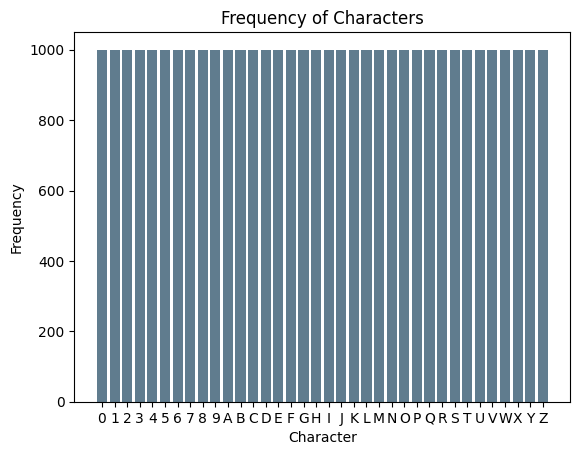

In [ ]:
import collections
# Plot a histogram of the labels
char_counts = collections.Counter(labels)

# Extract the characters and their corresponding counts
char_freq = list(char_counts.items())
char_freq.sort(key=lambda x: x[0])

# Plot a bar chart of the character frequencies
chars, counts = zip(*char_freq)
plt.bar(chars, counts, align='center', color='#607c8e')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.title('Frequency of Characters')
plt.show()

In [ ]:
# Define a string that contains all the letters and digits
characters = string.ascii_uppercase + string.digits

# Define a dictionary that maps each character to its one-hot vector representation
char_to_vec = {char: [int(char == c) for c in characters] for char in characters}

# Convert each label to its one-hot vector representation
one_hot_labels = [char_to_vec[str(label)] for label in labels]

In [ ]:
def custom_augmentation(image, scale_x, scale_y, original_width = 30, original_height =36):
    # Calculate translation bounds based on scaling factors
    translate_x_bound = ((1.05 - scale_x) * original_width) / 2
    translate_y_bound = ((1.05 - scale_y) * original_height) / 2

    translate_x = int(np.round(np.random.uniform(-translate_x_bound, translate_x_bound)))
    translate_y = int(np.round(np.random.uniform(-translate_y_bound, translate_y_bound)))

    # Define the augmentations
    seq = iaa.Sequential([
        iaa.Affine(
            scale={"x": (scale_x, scale_x), "y": (scale_y, scale_y)},
            translate_px={"x": (translate_x, translate_x), "y": (translate_y, translate_y)},
            order=[0, 1],
            cval=(0, 255),
            mode="constant"
        ),
        iaa.SaltAndPepper(p=0.05),
        iaa.GaussianBlur(sigma=(0, 1.0)),
        iaa.AdditiveGaussianNoise(scale=(0, 0.1 * 255)),
        iaa.MotionBlur(k=(3, 3), angle=(-10, 10)),
        iaa.PerspectiveTransform(scale=(0.01, 0.1), keep_size=True, cval=0),
        iaa.ShearX((-15, 15)),
        iaa.ShearY((-15, 15)),
        iaa.LinearContrast((0.9, 1.3)),
        iaa.AddToHueAndSaturation((-5, 5)),
        iaa.Resize({"height": "keep", "width": "keep"})
    ])

    # Apply the augmentations to the image
    aug_img = seq(image=image)
    aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2GRAY)
    return aug_img

augmented_images = []

for image in shuffled_images:
  scale_x = np.random.uniform(0.7, 1.1)
  scale_y = np.random.uniform(0.5, 1.0)
  augmented_images.append(custom_augmentation(image, scale_x, scale_y))



In [ ]:
for i in range(20):
  cv2_imshow(augmented_images[i])
  print(shuffled_labels[i])

R


J


B


U


B


W


5


I


1


6


X


G


4


M


2


3


E


1


0


M


In [ ]:
X_dataset = np.array(augmented_images)
Y_dataset = np.array(one_hot_labels)

In [ ]:
# for i in range(20,30):
#     print(labels[i])
#     cv2_imshow(X_dataset[i])

In [ ]:
VALIDATION_SPLIT = 0.2

split_index = math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT))

X_train_dataset = X_dataset[:split_index]
Y_train_dataset = Y_dataset[:split_index]

X_val_dataset = X_dataset[split_index:]
Y_val_dataset = Y_dataset[split_index:]

# In this case we do not define a test set.

print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))
print("Total examples: {:d}\nTraining examples: {:d}\n"
      "Validation examples: {:d}".
      format(X_dataset.shape[0],
             X_train_dataset.shape[0],
             X_val_dataset.shape[0]))

X shape: (36000, 36, 30)
Y shape: (36000, 36)
Total examples: 36000
Training examples: 28800
Validation examples: 7200


In [ ]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                              input_shape=(36, 30, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(36, activation='softmax'))

save_path = '/content/drive/MyDrive/Training/characterRecogModel.h5'
model = models.load_model(save_path)

In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
LEARNING_RATE = 1e-4
model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [ ]:
reset_weights(model)
history_conv = model.fit(X_train_dataset, Y_train_dataset, validation_split=VALIDATION_SPLIT, epochs=50)

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/50
720/720 [==============================] - 12s 5ms/step - loss: 3.7822 - accuracy: 0.1914 - val_loss: 1.7905 - val_accuracy: 0.5278
Epoch 2/50
720/720 [==============================] - 3s 5ms/step - loss: 1.8571 - accuracy: 0.4565 - val_loss: 1.1140 - val_accuracy: 0.6979
Epoch 3/50
720/720 [==============================] - 4s 6ms/step - loss: 1.3718 - accuracy: 0.5906 - val_loss: 0.7719 - val_accuracy: 0.7762
Epoch 4/50
720/720 [==============================] - 3s 5ms/step - loss: 1.0909 - accuracy: 0.6707 - val_loss: 0.6301 - val_accuracy: 0.8139
Epoch 5/50
720/720 [==============================] - 3s 4ms/step - loss: 0.9054 - accuracy: 0.7213 - val_loss: 0.5157 - val_accuracy: 0.8535
Epoch 6/50
720/720 [==============================] - 4s 5ms/step - loss: 0.7625 - accuracy: 0.7681 - val_loss: 0.4063 - val_accuracy: 0.8786
Epoch 7/50
720/720 [==============================] - 4s 6ms/step - loss: 0.6591 - accuracy: 0.7934 - val_loss: 0.3591 - val_accuracy: 0.8906
Epoch

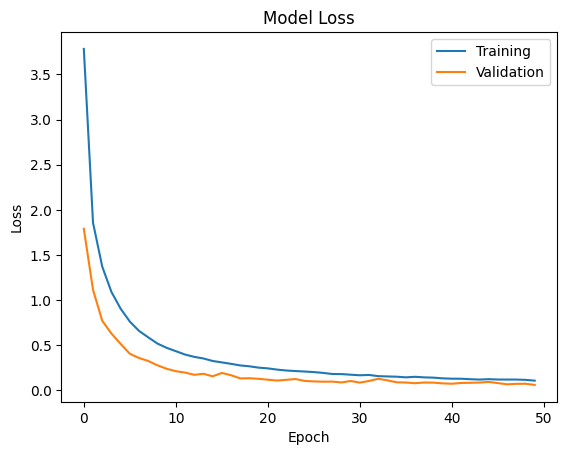

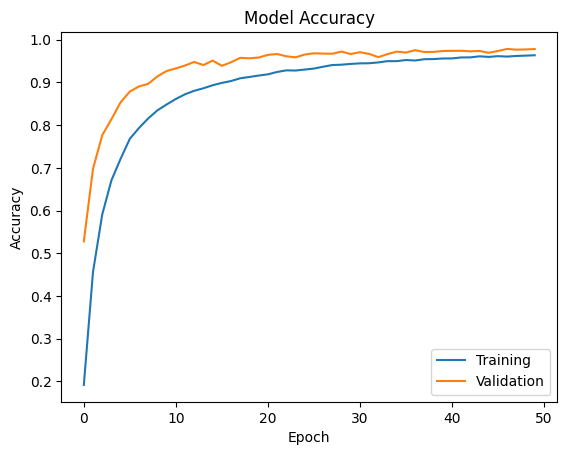

In [ ]:
history = history_conv
# Plot loss vs. epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot accuracy vs. epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [ ]:
save_path = '/content/drive/MyDrive/Training/characterRecogModelV2.h5'
model.save(save_path)

# Testing

interactive(children=(IntSlider(value=10, description='index', max=35999), Output()), _dom_classes=('widget-in…

<function __main__.displayImage(index)>

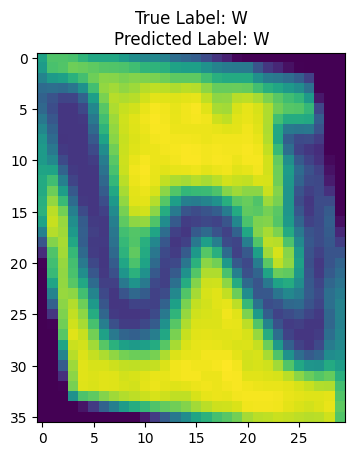

In [ ]:
# Define a function to convert a one-hot vector to a string
def onehot_to_string(onehot):
    # Define a dictionary mapping indices to characters
    char_dict = {
        0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 8: "I",
        9: "J", 10: "K", 11: "L", 12: "M", 13: "N", 14: "O", 15: "P", 16: "Q", 17: "R",
        18: "S", 19: "T", 20: "U", 21: "V", 22: "W", 23: "X", 24: "Y", 25: "Z",
        26: "0", 27: "1", 28: "2", 29: "3", 30: "4", 31: "5", 32: "6", 33: "7", 34: "8", 35: "9"
    }

    # Find the index of the maximum value in the one-hot vector
    index = np.argmax(onehot)

    # Return the corresponding character from the dictionary
    return char_dict[index]

# Define a function to display the image and its corresponding label
def displayImage(index):
    img = X_dataset[index]
    label = Y_dataset[index]

    # Predict the label for the image
    img_aug = np.expand_dims(img, axis=0)
    y_predict = model.predict(img_aug)[0]

    # Convert the predicted label to a string
    y_predict_str = onehot_to_string(y_predict)
    label = onehot_to_string(label)

    # Display the image and its corresponding label
    plt.imshow(img)
    plt.title(f"True Label: {label}\nPredicted Label: {y_predict_str}")

# Use ipywidgets to interactively display the images and their labels
interact(displayImage,
         index=ipywidgets.IntSlider(min=0, max=X_dataset.shape[0]-1, step=1, value=10))


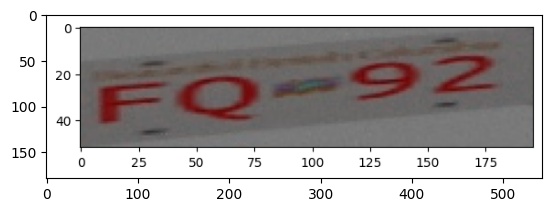

In [ ]:
file_path = '/content/licence_plate_353.png'


# Load the PNG file using OpenCV
img = cv2.imread(file_path)
plt.imshow(img)

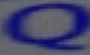

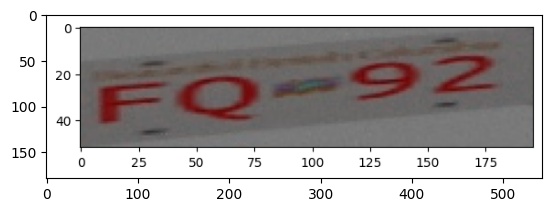

In [ ]:
file_path = '/content/licence_plate_353.png'


# Load the PNG file using OpenCV
img = cv2.imread(file_path)
plt.imshow(img)

# 120, 100
# test_image = img[70:120,55:135]
test_image = img[65:120,140:230]
cv2_imshow(test_image)
resized_image = cv2.resize(test_image, (30, 36))

# Display the resized image
cv2_imshow(resized_image)

In [ ]:
# Load the PNG file using OpenCV
img = resized_image
# label = Y_dataset[index]
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img.shape

(36, 30)

(1, 36, 30)
1/1 [==============================] - 0s 19ms/step


Text(0.5, 1.0, 'Predicted Label: 0')

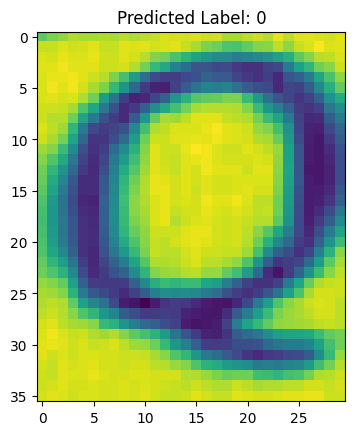

In [ ]:
# Define a function to convert a one-hot vector to a string
def onehot_to_string(onehot):
    # Define a dictionary mapping indices to characters
    char_dict = {
        0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 8: "I",
        9: "J", 10: "K", 11: "L", 12: "M", 13: "N", 14: "O", 15: "P", 16: "Q", 17: "R",
        18: "S", 19: "T", 20: "U", 21: "V", 22: "W", 23: "X", 24: "Y", 25: "Z",
        26: "0", 27: "1", 28: "2", 29: "3", 30: "4", 31: "5", 32: "6", 33: "7", 34: "8", 35: "9"
    }

    # Find the index of the maximum value in the one-hot vector
    index = np.argmax(onehot)

    # Return the corresponding character from the dictionary
    return char_dict[index]

# Load the PNG file using OpenCV
img = resized_image
# label = Y_dataset[index]
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Predict the label for the image
img_aug = np.expand_dims(img, axis=0)
# img_aug = img

print(img_aug.shape)
y_predict = model.predict(img_aug)[0]

# Convert the predicted label to a string
y_predict_str = onehot_to_string(y_predict)
# label = onehot_to_string(label)

# Display the image and its corresponding label
plt.imshow(img)
plt.title(f"Predicted Label: {y_predict_str}")


In [ ]:
save_path = '/content/drive/MyDrive/Training/characterRecogModel.h5'
model.save(save_path)